
# **0. 준비**

In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fo

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


---

# **1. 사과 데이터 불러오기**

- 제공받은 apple 데이터

In [ ]:
# 제공받은 홍로 사과 데이터 불러오기
df = pd.read_excel("/home/work/.data/data/data.xlsx")

df_red = df[df['품종']=='홍로']
df_red

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b)
0,2015-09-07,김제,홍로,1,1,244.0,80.1,81.2,0.986453,36.246,43.666,14.0,0.232000,58.550,5.120,27.480
1,2015-09-07,김제,홍로,1,2,380.0,100.6,90.2,1.115299,43.423,30.485,13.2,0.206000,61.780,23.970,24.880
2,2015-09-07,김제,홍로,1,3,262.0,89.2,87.6,1.018265,36.949,40.532,14.3,0.184000,59.140,18.370,25.350
3,2015-09-07,김제,홍로,1,4,318.5,94.1,85.2,1.104460,36.838,36.821,14.3,0.204000,57.200,17.990,28.660
4,2015-09-07,김제,홍로,1,5,383.0,98.6,95.9,1.028154,28.420,33.037,15.2,0.204000,55.800,24.120,24.520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2022-09-07,포천,홍로,3,6,241.0,71.7,82.2,0.872263,38.123,42.944,14.7,0.177014,27.880,32.870,9.205
1446,2022-09-07,포천,홍로,3,7,229.5,75.2,82.9,0.907117,39.374,31.725,13.0,0.233696,48.265,22.760,19.215
1447,2022-09-07,포천,홍로,3,8,256.0,72.1,88.5,0.814689,37.407,37.291,13.9,0.181704,36.440,31.635,14.050
1448,2022-09-07,포천,홍로,3,9,221.5,71.7,80.9,0.886279,44.921,38.049,15.9,0.218152,33.630,31.535,12.210


---

#  **2. 사과 품질 칼럼 만들기**

타겟데이터인 품질 칼럼을 생성하고 이를 예측한다.

등급별 기준은 논문 사실에 기재된 농촌진흥청 자료와 소비자 선호 기사를 바탕으로 한다.

* 등급별 기준

 - 과중: 320 / 350 / 215 / 그 미만

 - 당도: 14 / 14/ 12 / 그 미만

 - 당산비: 41 / 36 / 그 미만

In [ ]:
# 당산비 칼럼 생성
df_red['당산비'] = df_red['당도'] / df_red['산도']

In [ ]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 1449
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   조사일     798 non-null    datetime64[ns]
 1   과원이름    798 non-null    object        
 2   품종      798 non-null    object        
 3   시험수     798 non-null    int64         
 4   과실번호    798 non-null    int64         
 5   과중      791 non-null    float64       
 6   종경      776 non-null    float64       
 7   횡경      776 non-null    float64       
 8   L/D 비   776 non-null    float64       
 9   경도1     776 non-null    float64       
 10  경도2     776 non-null    float64       
 11  당도      790 non-null    float64       
 12  산도      663 non-null    float64       
 13  착색(L)   791 non-null    float64       
 14  착색(a)   791 non-null    float64       
 15  착색(b)   791 non-null    float64       
 16  당산비     663 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(2), object(2

In [ ]:
# 당도, 과중, 당산비 칼럼 null값 평균으로 채우기
mean_values = df_red[['당산비', '당도', '과중']].mean()
df_red[['당산비', '당도', '과중']] = df_red[['당산비', '당도', '과중']].fillna(mean_values)

In [ ]:
# '품질' 칼럼 초기화
df_red['품질'] = np.nan
df_red['품질'] = df_red['품질'].astype(str)

# 조건에 따라 '품질' 칼럼 값 설정
for index, row in df_red.iterrows():
    if row['당도']>=14 and row['과중']>=320 and row['당산비']>=41:
        df_red.at[index, '품질'] = '1등급'
    elif row['당도']>=14 and row['과중']>=250 and row['당산비']>=36 :
        df_red.at[index, '품질'] = '2등급'
    elif row['당도']>=12 and row['과중']>=215:
        df_red.at[index, '품질'] = '3등급'
    else:
        df_red.at[index, '품질'] = '4등급'

In [ ]:
print('1등급 사과 수: ', len(df_red[df_red['품질']=='1등급']))
print('2등급 사과 수: ', len(df_red[df_red['품질']=='2등급']))
print('3등급 사과 수: ', len(df_red[df_red['품질']=='3등급']))
print('4등급 사과 수: ', len(df_red[df_red['품질']=='4등급']))

1등급 사과 수:  107
2등급 사과 수:  136
3등급 사과 수:  432
4등급 사과 수:  123


In [ ]:
df_red.head()

,조사일,과원이름,품종,시험수,과실번호,과중,종경,횡경,L/D 비,경도1,경도2,당도,산도,착색(L),착색(a),착색(b),당산비,품질
0,2015-09-07,김제,홍로,1,1,244.0,80.1,81.2,0.986453,36.246,43.666,14.0,0.232,58.55,5.12,27.48,60.344828,3등급
1,2015-09-07,김제,홍로,1,2,380.0,100.6,90.2,1.115299,43.423,30.485,13.2,0.206,61.78,23.97,24.88,64.077670,3등급
2,2015-09-07,김제,홍로,1,3,262.0,89.2,87.6,1.018265,36.949,40.532,14.3,0.184,59.14,18.37,25.35,77.717391,2등급
3,2015-09-07,김제,홍로,1,4,318.5,94.1,85.2,1.104460,36.838,36.821,14.3,0.204,57.20,17.99,28.66,70.098039,2등급
4,2015-09-07,김제,홍로,1,5,383.0,98.6,95.9,1.028154,28.420,33.037,15.2,0.204,55.80,24.12,24.52,74.509804,1등급


---

# **3. 기상데이터 + 사과 데이터 병합**

최종적으로 상관분석 및 모델링에 사용할 데이터는 사과 데이터에 맞는 기상데이터가 병합된 것이다.

### 1) 기상데이터 불러오기

제공받은 사과 데이터에 속하는 지점과 기간을 선택하여 기상청에서 데이터를 수집하였다.

In [ ]:
weather= pd.read_csv('/home/work/.data/data/weather.csv', sep=',',encoding='cp949')

# 원래 날짜 형식과 변경할 날짜 형식 정의
date_formats = ["%b-%y", "%y-%m"]

# 날짜 형식 변경 함수 정의
def convert_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, date_formats[0])
    return date_obj.strftime(date_formats[1])

# 날짜 열을 변경하고 새로운 열에 저장
weather['일시'] = weather['일시'].apply(convert_date)

In [ ]:
weather

,지점,지점명,일시,평균기온(°C),평균최고기온(°C),평균최저기온(°C),최고기온(°C),최저기온(°C),평균상대습도(%),월합강수량(00~24h만)(mm),일최다강수량(mm),1시간최다강수량(mm),평균풍속(m/s),최대풍속(m/s),최다풍향(16방위),합계 일조시간(hr),일조율(%),합계 일사량(MJ/m2),평균지면온도(°C)
0,93,북춘천,16-10,14.1,20.9,8.6,29.0,-1.9,74,112.1,39.0,20.5,0.9,6.0,70,185.3,53.29,381.67,15.7
1,93,북춘천,16-11,5.1,11.2,-0.5,19.5,-9.1,71,13.2,5.5,NaN,0.9,5.5,50,147.4,48.44,259.88,6.2
2,93,북춘천,16-12,-0.2,5.3,-5.0,10.2,-12.1,74,83.1,49.0,NaN,0.8,6.4,230,142.3,47.80,204.42,0.6
3,93,북춘천,17-01,-3.4,3.3,-9.8,11.6,-17.0,66,15.9,7.1,NaN,1.1,7.7,50,204.2,66.60,286.30,-1.9
4,93,북춘천,17-02,-1.5,5.4,-8.2,12.2,-15.7,64,11.0,3.5,NaN,1.2,6.5,50,214.9,71.04,356.79,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,146,전주,16-04,14.6,21.3,9.7,26.4,5.2,69,144.2,29.0,10.1,1.9,13.5,270,186.1,47.26,526.14,16.1
530,146,전주,16-05,19.2,25.7,13.6,30.1,9.6,67,84.3,22.9,7.2,2.1,10.2,140,277.9,63.69,709.69,21.8
531,146,전주,16-06,22.8,27.8,19.1,31.3,15.7,80,95.8,38.0,38.0,1.6,8.2,270,171.5,39.25,557.71,25.9
532,146,전주,16-07,26.5,31.0,23.2,34.5,20.4,83,251.8,57.4,27.2,1.7,6.8,140,184.7,41.61,564.96,30.7


하지만, 위의 weather 데이터 프레임은 지점과 날짜에 해당하는 기상데이터이며 우리가 필요한 것은 사과가 자라온 환경에 대한 데이터이다.

따라서 사과 데이터에서 **조사일자로부터 12개월 전의 모든 기상데이터**를 가져와 변수로 만들어주어야한다.

아래 코드는 이에 대한 과정 및 결과이다.

### 2) 과원위치별로 날씨데이터 병합 for문

- 기상지점 칼럼 : 과원에 따라 가까운 기상 관측지점으로, 제공받은 주소와 가장 가까운 위치 입력

In [ ]:
# 과원이름에 따른 기상지점을 데이터프레임에 새로운 칼럼으로 생성
df_red['기상지점'] = df_red['과원이름'].map({
    '화성': '수원',
    '포천': '동두천',
    '김제': '전주',
    '완주': '전주',
    '남해': '남해',
    '충주': '충주',
    '춘천': '북춘천',
    '군위': '대구'
})

# 기상데이터 칼럼
selected_columns = [
    '평균기온(°C)', '평균최고기온(°C)', '평균최저기온(°C)',
    '평균상대습도(%)','월합강수량(00~24h만)(mm)',
    '평균풍속(m/s)', '최대풍속(m/s)',
    '일조율(%)', '합계 일사량(MJ/m2)', '평균지면온도(°C)'
]

# 처리할 지점들의 리스트
locations = ['전주', '북춘천', '동두천', '수원', '충주', '대구', '남해']

# 결과를 저장할 빈 리스트
df_result_list = []

# 각 지점에 대한 처리를 반복
for location in locations:

    # 해당 지점의 기상 데이터 추출
    location_weather = weather[weather['지점명'] == location]
    location_weather.reset_index(drop=True, inplace=True)

    # '일시' 열을 기반으로 연도와 월을 분리
    location_weather['연도'] = location_weather['일시'].str.split('-').str[0].astype(int)
    location_weather['월'] = location_weather['일시'].str.split('-').str[1].astype(int)

    # 결과 데이터프레임 초기화
    weather_result = pd.DataFrame()

    # 연도별로 데이터를 처리
    for year in range(14, 23):
        year_df = location_weather[location_weather['연도'] == year]

        # 월별로 열을 재구성
        monthly_data = []

        for month in range(1, 13):
            month_data = year_df[year_df['월'] == month][selected_columns].mean()
            monthly_data.extend(month_data)

        # 결과 데이터프레임에 추가
        weather_result = weather_result.append(pd.Series(monthly_data, name=year))

    # 컬럼 이름 재구성
    new_columns = [f"{month}월 {col}" for month in range(1, 13) for col in selected_columns]
    weather_result.columns = new_columns

    # 해당 지점 (타겟이 있는) 데이터프레임 추출
    location_df = df_red[df_red['기상지점'] == location]
    location_df['조사일'] = pd.to_datetime(location_df['조사일'])  # 데이트타임으로 변환
    location_df.drop('기상지점', axis=1, inplace=True)
    location_df.reset_index(drop=True, inplace=True)  # 인덱스 초기화!

    n = len(location_df)

    for i in range(n):
        year = int(str(location_df['조사일'][i])[2:4])
        month = int(str(location_df['조사일'][i])[5:7])
        day = int(str(location_df['조사일'][i])[8:10])

        #'조사일' 전년도와 조사일년도 추출
        location_weather = weather_result.loc[[year - 1, year]]
        location_weather_flatten = location_weather.values.flatten()

        # condition = 사용할 기상데이터 종류
        condition = int(len(location_weather_flatten) / 12 / 2)

        # 15일 전 데이터는 해당 월의 영향이 적었을 것이라 판단.
        # 15일 전에는 '조사일'에 해당하는 월 제외
        if day <= 15:
            data1 = location_weather.values[1:, :(condition * (month - 1))]
            data2 = location_weather.values[:1, (condition * (month - 1)):]
            result = np.hstack((data1, data2))
            result = result[0]
        else:
            data1 = location_weather.values[1:, :(condition * (month))]
            data2 = location_weather.values[:1, (condition * (month)):]
            result = np.hstack((data1, data2))
            result = result[0]

        df_result = pd.DataFrame({
            '조사일': [location_df['조사일'][i]],
            '과원이름': [location_df['과원이름'][i]],
            **{f'{int(j / condition) + 1}월 평균 기온(°C)': result[j] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균 최고기온(°C)': result[j + 1] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균 최저기온(°C)': result[j + 2] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균 상대습도(%)': result[j + 3] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 월합강수량(00~24h만)(mm)': result[j + 4] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균풍속(m/s)': result[j + 5] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 최대풍속(m/s)': result[j + 6] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 일조율(%)': result[j + 7] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 합계 일사량(MJ/m2)': result[j + 8] for j in range(0, 12 * condition, condition)},
            **{f'{int(j / condition) + 1}월 평균지면온도(°C)': result[j + 9] for j in range(0, 12 * condition, condition)},
            '품질': [location_df['품질'][i]]
        })
        df_result_list.append(df_result)

# 모든 결과를 하나의 데이터프레임으로 병합
final_df_result = pd.concat(df_result_list, ignore_index=True)

In [ ]:
# 조사일과 과원이름으로 정렬
final_df_result.sort_values(by=['조사일', '과원이름'], inplace=True)
final_df_result.tail(3)

,조사일,과원이름,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),8월 평균 기온(°C),...,4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),품질
441,2022-09-07,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.7,15.8,6.6,-0.5,3등급
442,2022-09-07,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.7,15.8,6.6,-0.5,3등급
443,2022-09-07,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.7,15.8,6.6,-0.5,3등급


In [ ]:
# final_df_result 데이터 프레임을 복제하여 red_df_result 변수로 지정
red_df_result = final_df_result.copy()

In [ ]:
# 인덱스 reset
red_df_result.reset_index(drop=True, inplace=True)
red_df_result.tail(3)

,조사일,과원이름,1월 평균 기온(°C),2월 평균 기온(°C),3월 평균 기온(°C),4월 평균 기온(°C),5월 평균 기온(°C),6월 평균 기온(°C),7월 평균 기온(°C),8월 평균 기온(°C),...,4월 평균지면온도(°C),5월 평균지면온도(°C),6월 평균지면온도(°C),7월 평균지면온도(°C),8월 평균지면온도(°C),9월 평균지면온도(°C),10월 평균지면온도(°C),11월 평균지면온도(°C),12월 평균지면온도(°C),품질
795,2022-09-07,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.7,15.8,6.6,-0.5,3등급
796,2022-09-07,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.7,15.8,6.6,-0.5,3등급
797,2022-09-07,포천,-3.9,-2.6,6.4,13.6,17.4,21.5,25.8,24.2,...,17.9,24.4,24.8,29.1,27.2,23.7,15.8,6.6,-0.5,3등급


정리하면, red_df_result는 제공받은 사과 데이터에서 조사일과, 과원이름에 맞춰 기상데이터를 넣은 데이터프레임이다.

---

# **4. 상관분석**

1)  스피어만 상관계수(비모수검정)

* 데이터가 서열척도인 경우 자료의 값에 순위를 매겨 상관계수 계산(ex. 언어영역 등수와 수리영역 등수 간의 상관관계)

* 데이터 내의 편차와 에러에 민감하며, 일반적으로 켄달계수보다 높은 값을 가짐

2) 켄달의 순위상관계수 (비모수검정)

* 두 변수들 간의 순위를 비교하여 연관성을 계산

* 표본 사이즈가 작거나 데이터의 동률이 많을 때 사용


In [ ]:
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

### 1. 스피어만 상관계수

In [ ]:
# '품질' 칼럼을 숫자로 변환
red_df_result['품질'] = red_df_result['품질'].map({'1등급': 1, '2등급': 2, '3등급': 3, '4등급': 4})

# '품질' 칼럼과 다른 연속형 변수들 간의 상관계수 계산
correlation_matrix = red_df_result.corr(method='spearman')

# '품질' 칼럼과의 상관계수만 추출 및 정렬
quality_correlation = correlation_matrix['품질'].sort_values(ascending=False)

quality_correlation[1:12]

9월 월합강수량(00~24h만)(mm)     0.249859
1월 일조율(%)                 0.184309
12월 일조율(%)                0.181448
10월 월합강수량(00~24h만)(mm)    0.172656
7월 월합강수량(00~24h만)(mm)     0.143951
1월 평균 최고기온(°C)            0.106416
11월 평균 최고기온(°C)           0.102046
11월 월합강수량(00~24h만)(mm)    0.096054
5월 일조율(%)                 0.088263
1월 합계 일사량(MJ/m2)          0.078290
2월 월합강수량(00~24h만)(mm)     0.078054
Name: 품질, dtype: float64

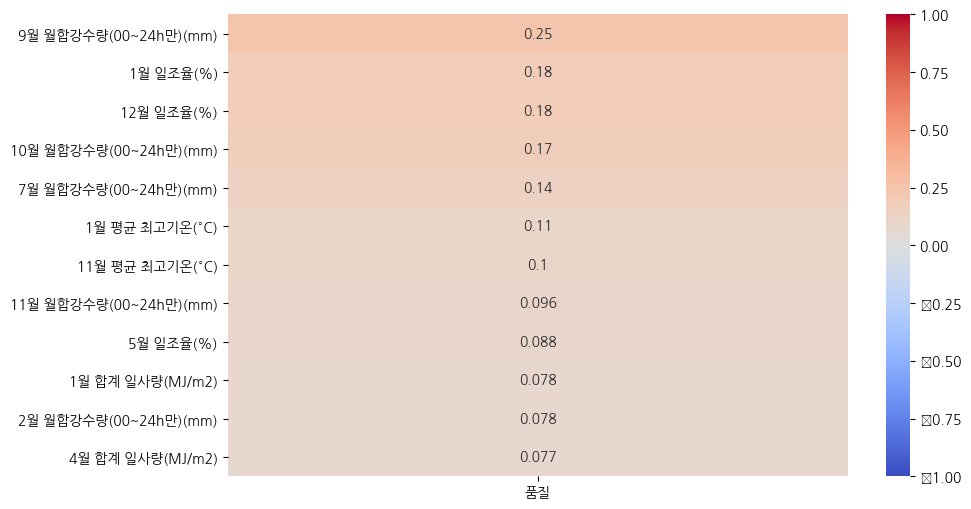

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(quality_correlation[1:13].to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### 2. 켄달의 상관계수

In [ ]:
# '품질' 칼럼과 다른 연속형 변수들 간의 상관계수 계산
correlation_matrix2 = red_df_result.corr(method='kendall')

# '품질' 칼럼과의 상관계수만 추출 및 정렬
quality_correlation2 = correlation_matrix2['품질'].sort_values(ascending=False)

quality_correlation2[1:12]

9월 월합강수량(00~24h만)(mm)     0.194541
1월 일조율(%)                 0.141701
12월 일조율(%)                0.139327
10월 월합강수량(00~24h만)(mm)    0.135638
7월 월합강수량(00~24h만)(mm)     0.113344
1월 평균 최고기온(°C)            0.081977
11월 평균 최고기온(°C)           0.077835
11월 월합강수량(00~24h만)(mm)    0.076824
5월 일조율(%)                 0.070273
4월 합계 일사량(MJ/m2)          0.061876
1월 합계 일사량(MJ/m2)          0.061068
Name: 품질, dtype: float64

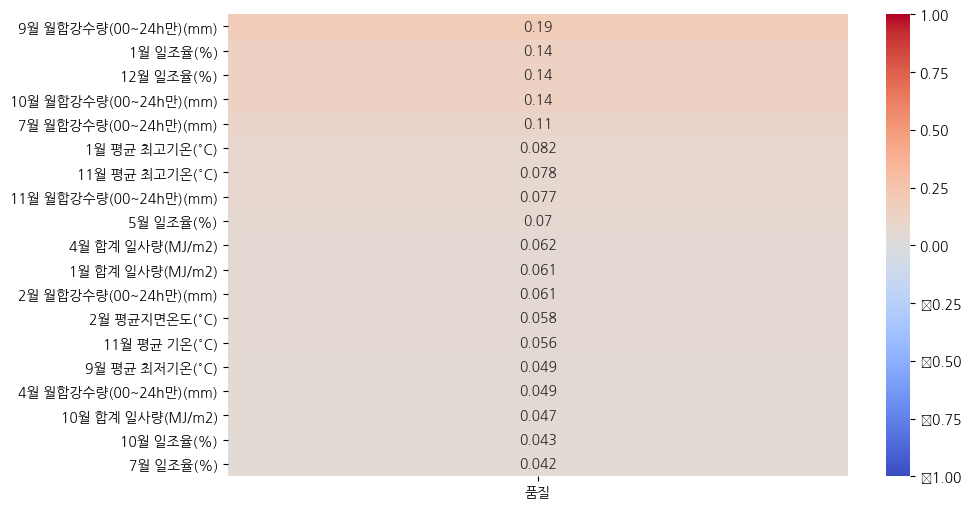

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(quality_correlation2[1:20].to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

=> 두 상관계수의 결과가 거의 동일하다.

---

# **5. 상관분석 후 데이터 프레임**

스피어만 상관분석으로 뽑은 변수 11개와 조사일, 과원이름, 품질 칼럼만 남아있는 데이터 프레임 생성

In [ ]:
# 스피어만 상관계수를 활용하여 얻어낸 변수 10개만 사용하도록 지정
selected_cols = quality_correlation[1:11].index
selected_cols = ['조사일', '과원이름'] + list(selected_cols) #조사일, 과원이름 칼럼은 삭제x
red_df_corr = red_df_result[selected_cols]
red_df_corr['품질'] = red_df_result['품질']

In [ ]:
# 최종 데이터프레임
red_df_corr

,조사일,과원이름,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질
0,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3
1,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3
2,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2
3,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2
4,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3
794,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3
795,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3
796,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3


---

# **6. 새로운 변수 추가**

### (1) 태풍 칼럼 추가

-> 태풍은 수확기에 가까운 태풍에만 영향을 받으므로 작년 수확기 이후의 태풍은 고려하지 않았다.

즉, 당해 연도의 태풍 발생만 고려하였다. 따라서 지금까지 기상데이터는 월별 데이터였지만 태풍 칼럼은 연도별 데이터로 입력된다.

* 연도별 발생 횟수:

    2015: 4회   |   2016: 2회   |  2017: 3회

    2018: 5회   |   2019: 7회   |  2020: 4회

    2021: 3회   |   2022: 5회


* 태풍 평균 강도 = 각 태풍의 최대 풍속 / 당해 연도 발생 횟수


In [ ]:
# 조사일에서 연도 추출
red_df_corr['조사연도'] = 0
for i in range(len(red_df_corr)):
    red_df_corr['조사연도'].iloc[i] = final_df_result['조사일'].iloc[i].year

red_df_corr.head()

,조사일,과원이름,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질,조사연도
0,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015
1,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015
2,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015
3,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015
4,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,1,2015


In [ ]:
# 2015~2022년 태풍횟수와 태풍평균강도 칼럼 생성
red_df_corr['태풍횟수'] = red_df_corr['조사연도'].map({
        2015: 4,
        2016: 2,
        2017: 3,
        2018: 5,
        2019: 7,
        2020: 4,
        2021: 3,
        2022: 5
})

red_df_corr['태풍평균강도'] = red_df_corr['조사연도'].map({
        2015: 54.25,
        2016: 49.5,
        2017: 41,
        2018: 40.2,
        2019: 38.57,
        2020: 42,
        2021: 34,
        2022: 33.6
        })

### (2) 폭염 일수 칼럼 추가

* 폭염 일수 : 지역 별로 각 수확년도에 체감온도가 33도 이상이었던 날 횟수

 - 위 변수인 태풍 횟수와 마찬가지로 연도별 데이터로 입력된다.

In [ ]:
# 폭염 일수
hot_dict = {
    '충주': [12, 28, 12, 37, 16, 6, 16, 10],
    '김제': [17, 39, 29, 48, 32, 25, 24, 22],
    '완주': [17, 39, 29, 48, 32, 25, 24, 22],
    '남해': [13, 37, 35, 42, 22, 14, 14, 9],
    '포천': [8, 31, 17, 36, 17, 9, 25, 15],
    '화성': [17, 37, 25, 41, 20, 14, 27, 17],
    '군위': [16, 29, 28, 35, 22, 29, 17, 39],
    '춘천': [None, None, 14, 29, 15, 10, 24, 16]
}

for region in hot_dict.keys():
    hot_list = hot_dict[region]
    for year, hot_days in zip(range(2015, 2023), hot_list):
        red_df_corr.loc[(final_df_result['과원이름'] == region) & (red_df_corr['조사연도'] == year), '폭염일수'] = hot_days

### (3) 장마 칼럼

: 정확한 구분을 위해 장마 일수와 합계 강수량 두 개의 칼럼 추가

In [ ]:
# (1) 장마 일수
rain_days = {
    '충주': [35, 37, 29, 16, 34, 54, 17, 33],
    '김제': [36, 29, 31, 14, 33, 38, 17, 33],
    '완주': [36, 29, 31, 14, 33, 38, 17, 33],
    '남해': [36, 29, 31, 14, 33, 38, 17, 33],
    '포천': [35, 37, 29, 16, 34, 54, 17, 33],
    '화성': [35, 37, 29, 16, 34, 54, 17, 33],
    '군위': [36, 29, 31, 14, 33, 38, 17, 33],
    '춘천': [35, 37,29, 16, 34, 54, 17, 33]
}

for region in rain_days.keys():
    rain_day = rain_days[region]
    for year, days in zip(range(2015, 2023), rain_day):
        red_df_corr.loc[(final_df_result['과원이름'] == region) & (red_df_corr['조사연도'] == year), '장마일수'] = days

In [ ]:
# (2) 합계강수량
total_precipi_dict = {
    '충주': [228.3, 399.8, 375.3, 209.4, 169.1, 814.3, 304.5, 528],
    '김제': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '완주': [193.5, 320.3, 188, 289, 233.1, 682, 220.4, 262.6],
    '남해': [420.2, 309.6, 156.9, 482.8, 784.9, 843.6, 503, 249.1],
    '포천': [475.5, 456.1, 575.1, 268.9, 265, 1085.4, 115.8, 558.7],
    '화성': [242.2, 324.3, 579.7, 320.1, 185, 1057.9, 123.7, 622.9],
    '군위': [195, 189, 91.6, 266, 253.9, 381.6, 147.9, 124.8],
    '춘천': [257.8, 625.9, 530.4, 316.7, 174.5, 944.1, 156.4, 525]
}

for region in total_precipi_dict.keys():
    total_precipi_list = total_precipi_dict[region]
    for year, total_precipi in zip(range(2015, 2023), total_precipi_list):
        red_df_corr.loc[(final_df_result['과원이름'] == region) & (red_df_corr['조사연도'] == year), '합계강수량'] = total_precipi

In [ ]:
red_df_corr

,조사일,과원이름,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015,4,54.25,17.0,36.0,193.5
1,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015,4,54.25,17.0,36.0,193.5
2,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015,4,54.25,17.0,36.0,193.5
3,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015,4,54.25,17.0,36.0,193.5
4,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,1,2015,4,54.25,17.0,36.0,193.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1
794,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1
795,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1
796,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1


---

# **7. EDA**


- 다른 파일 참고

### **1) 데이터 확인**

In [ ]:
red_df_corr.head()

,조사일,과원이름,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015,4,54.25,17.0,36.0,193.5
1,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015,4,54.25,17.0,36.0,193.5
2,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015,4,54.25,17.0,36.0,193.5
3,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015,4,54.25,17.0,36.0,193.5
4,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,1,2015,4,54.25,17.0,36.0,193.5


In [ ]:
red_df_corr.tail()

,조사일,과원이름,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
793,2022-09-07,포천,100.6,70.05,62.2,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.6,9.0,33.0,249.1
794,2022-09-07,포천,100.6,70.05,62.2,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.6,9.0,33.0,249.1
795,2022-09-07,포천,100.6,70.05,62.2,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.6,9.0,33.0,249.1
796,2022-09-07,포천,100.6,70.05,62.2,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.6,9.0,33.0,249.1
797,2022-09-07,포천,100.6,70.05,62.2,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.6,9.0,33.0,249.1


In [ ]:
red_df_corr.shape

(798, 19)

In [ ]:
# 데이터 정보 확인
red_df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   조사일                     798 non-null    datetime64[ns]
 1   과원이름                    798 non-null    object        
 2   9월 월합강수량(00~24h만)(mm)   768 non-null    float64       
 3   1월 일조율(%)               798 non-null    float64       
 4   12월 일조율(%)              798 non-null    float64       
 5   10월 월합강수량(00~24h만)(mm)  798 non-null    float64       
 6   7월 월합강수량(00~24h만)(mm)   798 non-null    float64       
 7   1월 평균 최고기온(°C)          798 non-null    float64       
 8   11월 평균 최고기온(°C)         798 non-null    float64       
 9   11월 월합강수량(00~24h만)(mm)  798 non-null    float64       
 10  5월 일조율(%)               798 non-null    float64       
 11  1월 합계 일사량(MJ/m2)        525 non-null    float64       
 12  품질                      798 non-null    int64     

In [ ]:
# 데이터의 기술 통계량 확인
red_df_corr.describe()

,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
count,768.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,525.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,130.649219,61.739273,57.854536,84.107769,274.219674,4.103759,13.264787,45.537594,58.280752,276.257638,2.715539,2018.756892,4.289474,39.568083,24.609023,28.725564,334.039348
std,101.379001,7.719462,7.790794,68.071955,149.647855,2.098230,1.527851,31.495739,9.989561,26.238057,0.883721,1.835396,1.358154,4.081077,9.697043,11.580112,265.730355
min,25.300000,39.270000,42.750000,2.900000,100.200000,0.400000,9.900000,0.100000,43.970000,231.840000,1.000000,2015.000000,2.000000,33.600000,9.000000,16.000000,123.700000
25%,61.700000,57.220000,53.210000,28.700000,176.200000,2.600000,12.200000,17.600000,47.405000,249.400000,2.000000,2017.000000,3.000000,38.570000,16.000000,16.250000,188.000000
50%,130.400000,63.470000,57.700000,73.000000,222.700000,4.000000,13.400000,42.500000,63.490000,286.810000,3.000000,2018.000000,4.000000,40.200000,29.000000,31.000000,268.900000
75%,163.400000,66.970000,62.260000,112.100000,329.800000,5.600000,14.575000,73.900000,67.140000,298.100000,3.000000,2020.000000,5.000000,41.000000,36.000000,33.000000,304.500000
max,588.800000,71.840000,74.620000,315.800000,684.500000,8.500000,15.800000,104.200000,73.260000,311.430000,4.000000,2022.000000,7.000000,54.250000,39.000000,54.000000,1057.900000


<Axes: >

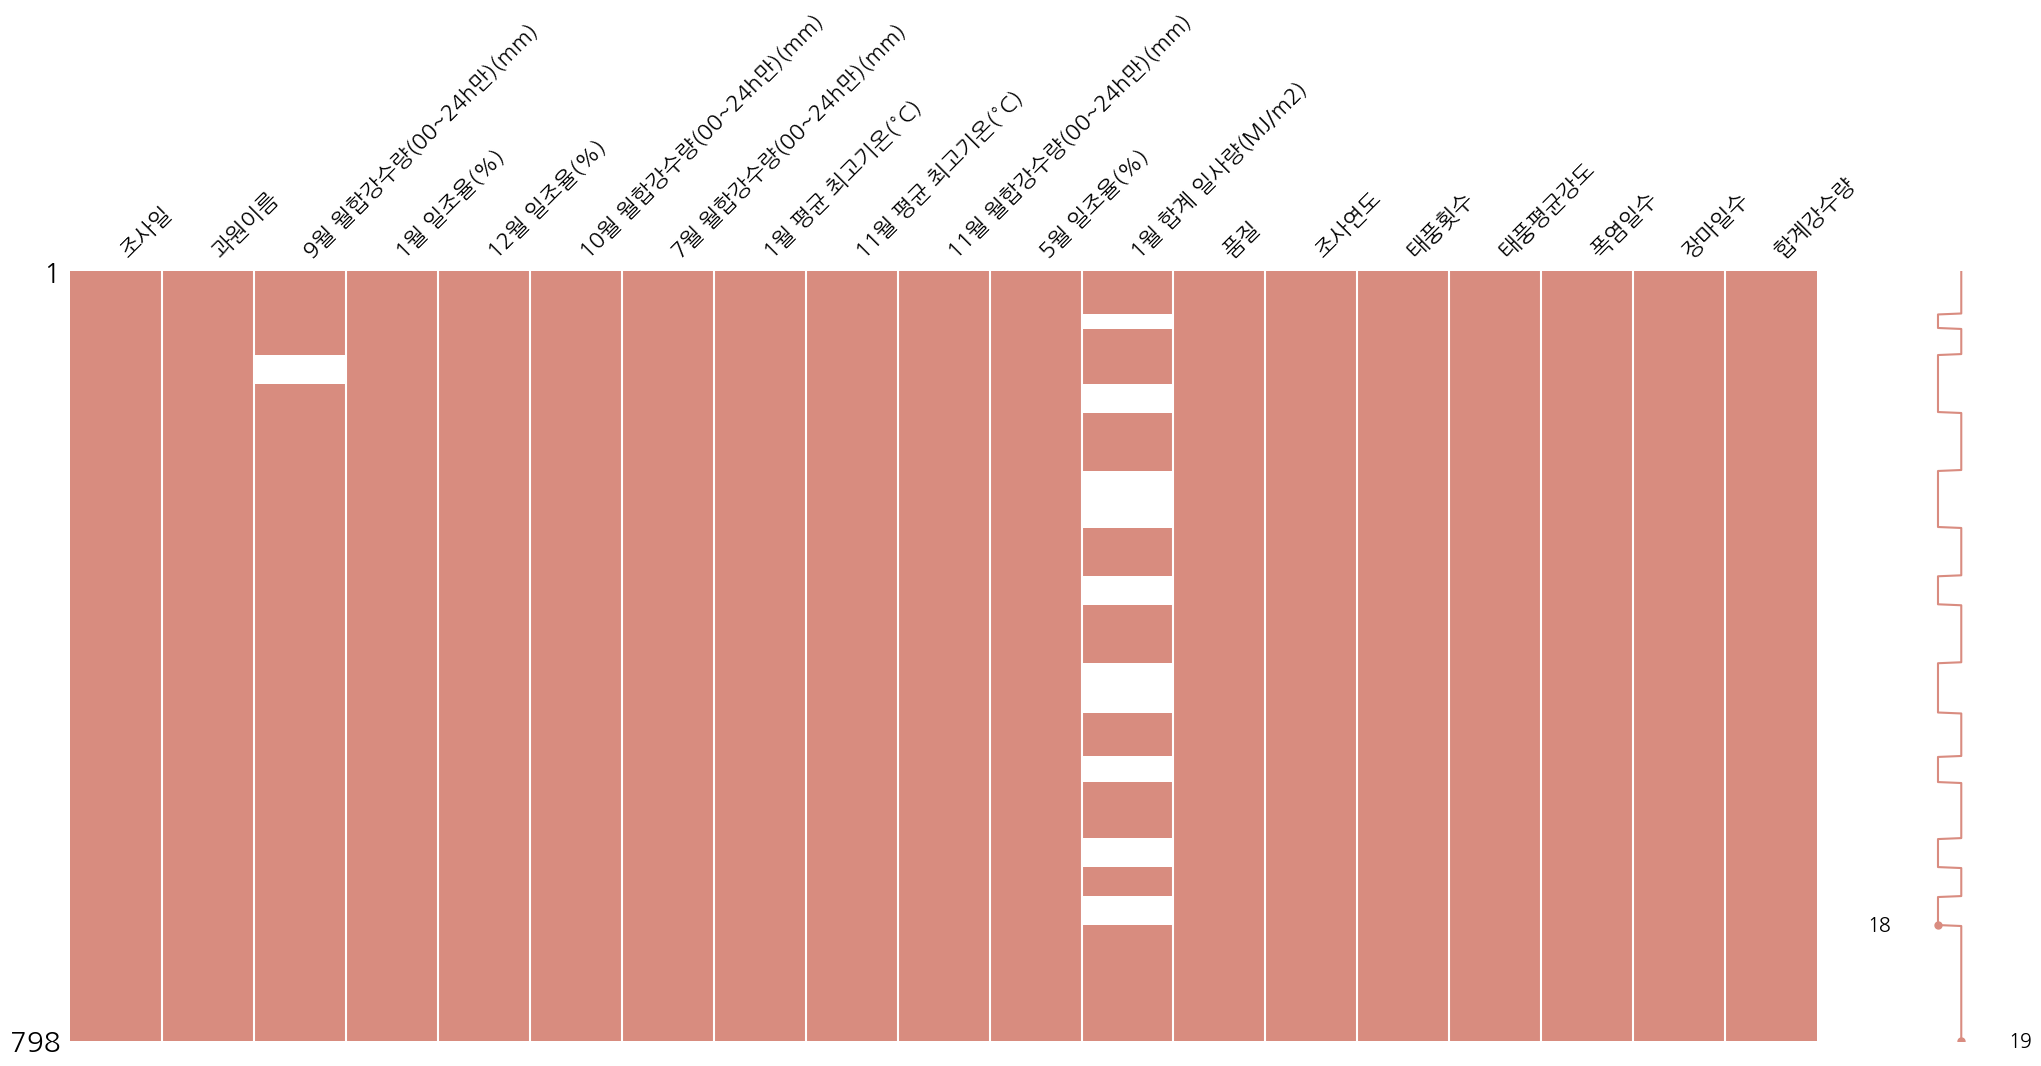

In [ ]:
# 데이터의 결측치 확인
import missingno as mino
mino.matrix(red_df_corr, color=(0.85, 0.55, 0.5))

=> 9월 월합강수량, 1월 합계 일사량 에 null 값이 존재한다.

In [ ]:
red_df_corr.isnull().sum()

조사일                         0
과원이름                        0
9월 월합강수량(00~24h만)(mm)      30
1월 일조율(%)                   0
12월 일조율(%)                  0
10월 월합강수량(00~24h만)(mm)      0
7월 월합강수량(00~24h만)(mm)       0
1월 평균 최고기온(°C)              0
11월 평균 최고기온(°C)             0
11월 월합강수량(00~24h만)(mm)      0
5월 일조율(%)                   0
1월 합계 일사량(MJ/m2)          273
품질                          0
조사연도                        0
태풍횟수                        0
태풍평균강도                      0
폭염일수                        0
장마일수                        0
합계강수량                       0
dtype: int64

In [ ]:
# 결측치를 평균으로 변경
null_columns = red_df_corr.columns[red_df_corr.isnull().any()]
for col in null_columns:
    mean_value = red_df_corr[col].mean()
    red_df_corr[col].fillna(mean_value, inplace=True)

In [ ]:
# 결측치 갯수 확인
red_df_corr.isnull().sum()

조사일                       0
과원이름                      0
9월 월합강수량(00~24h만)(mm)     0
1월 일조율(%)                 0
12월 일조율(%)                0
10월 월합강수량(00~24h만)(mm)    0
7월 월합강수량(00~24h만)(mm)     0
1월 평균 최고기온(°C)            0
11월 평균 최고기온(°C)           0
11월 월합강수량(00~24h만)(mm)    0
5월 일조율(%)                 0
1월 합계 일사량(MJ/m2)          0
품질                        0
조사연도                      0
태풍횟수                      0
태풍평균강도                    0
폭염일수                      0
장마일수                      0
합계강수량                     0
dtype: int64

In [ ]:
red_df_corr

,조사일,과원이름,9월 월합강수량(00~24h만)(mm),1월 일조율(%),12월 일조율(%),10월 월합강수량(00~24h만)(mm),7월 월합강수량(00~24h만)(mm),1월 평균 최고기온(°C),11월 평균 최고기온(°C),11월 월합강수량(00~24h만)(mm),5월 일조율(%),1월 합계 일사량(MJ/m2),품질,조사연도,태풍횟수,태풍평균강도,폭염일수,장마일수,합계강수량
0,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015,4,54.25,17.0,36.0,193.5
1,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,3,2015,4,54.25,17.0,36.0,193.5
2,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015,4,54.25,17.0,36.0,193.5
3,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,2,2015,4,54.25,17.0,36.0,193.5
4,2015-09-07,김제,88.1,49.28,47.38,101.1,121.9,5.9,14.9,75.0,63.48,249.98,1,2015,4,54.25,17.0,36.0,193.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1
794,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1
795,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1
796,2022-09-07,포천,100.6,70.05,62.20,71.2,302.7,2.6,13.3,51.6,69.19,291.73,3,2022,5,33.60,9.0,33.0,249.1


In [ ]:
#해당 데이터는 제공됐으므로 주석처리
#red_df_corr.to_excel('red_eda_data.xlsx', index=False)

---

# **8. 데이터 전처리**

* target data 라벨인코딩

In [ ]:
encoder = LabelEncoder()
encoder.fit(red_df_corr['품질'])
red_df_corr['품질'] = encoder.transform(red_df_corr['품질'])

* X, Y 분리

In [ ]:
y = red_df_corr[['품질']]
X = red_df_corr.drop(columns=['품질', '조사일', '조사연도','과원이름'])

* train, test 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

* 수치형 데이터 스케일링

In [ ]:
# X 변수들 스케일링
standard_scaler = StandardScaler()

columns = ['9월 월합강수량(00~24h만)(mm)', '1월 일조율(%)', '12월 일조율(%)',
            '10월 월합강수량(00~24h만)(mm)', '7월 월합강수량(00~24h만)(mm)', '1월 평균 최고기온(°C)',
            '11월 평균 최고기온(°C)', '11월 월합강수량(00~24h만)(mm)', '5월 일조율(%)',
            '1월 합계 일사량(MJ/m2)', '태풍횟수', '태풍평균강도', '폭염일수', '장마일수', '합계강수량']

train_numeric = X_train[columns]
test_numeric = X_test[columns]

stan_fit = standard_scaler.fit(train_numeric)
train_numeric_scaled = stan_fit.transform(train_numeric)
test_numeric_scaled = stan_fit.transform(test_numeric)

X_train[columns] = train_numeric_scaled
X_test[columns] = test_numeric_scaled

---

# **9. 모델 학습 및 예측**

In [ ]:
# 모델을 평가하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

## **1) xgbclassifier**

- grid search

In [ ]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost 분류 모델 생성
xgb = XGBClassifier(objective="multi:softprob", num_class=4, random_state=42)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), cv=3)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_xgb = grid_search.best_estimator_

# 모델 학습
best_xgb.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = best_xgb.predict(X_test)

- 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred)

오차 행렬
[[12  4 11  0]
 [ 2 13 19  0]
 [ 6  3 97  2]
 [ 2  2 15 12]]
정확도: 0.6700, 정밀도: 0.6758, 재현율: 0.6700, F1:0.6468


* feature importance

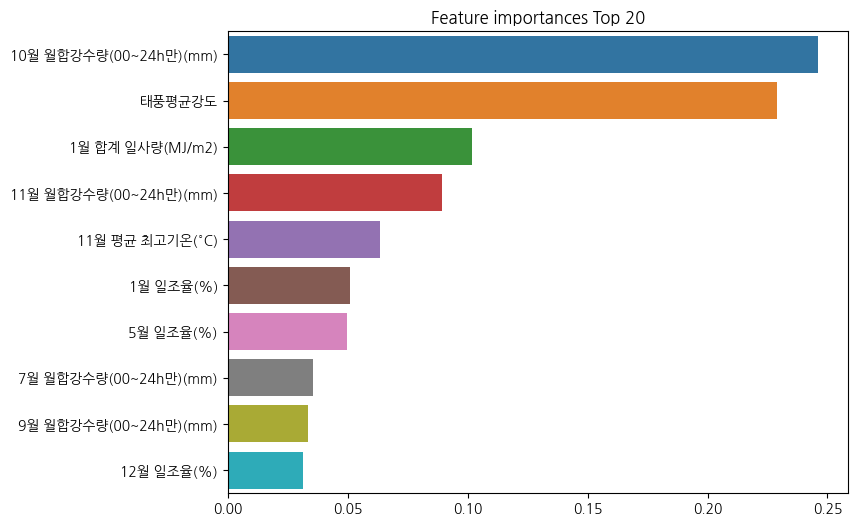

In [ ]:
ftr_importances_values = best_xgb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
ftr_top20

10월 월합강수량(00~24h만)(mm)    0.246124
태풍평균강도                    0.229043
1월 합계 일사량(MJ/m2)          0.102010
11월 월합강수량(00~24h만)(mm)    0.089279
11월 평균 최고기온(°C)           0.063463
1월 일조율(%)                 0.050810
5월 일조율(%)                 0.049739
7월 월합강수량(00~24h만)(mm)     0.035579
9월 월합강수량(00~24h만)(mm)     0.033628
12월 일조율(%)                0.031331
dtype: float32

## **2) randomforest**

* grid search

In [ ]:
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 7, 9],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [5, 7, 9],
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행 (n_jobs=-1: 모든 CPU 코어를 이용해 학습)
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
grid_search2 = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1)
grid_search2.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n',grid_search2.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_search2.best_score_))

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

최적 하이퍼 파라미터:
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
최고 예측 정확도: 0.6672


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_rf = grid_search2.best_estimator_

# 모델 학습
best_rf.fit(X_train, y_train)

# 검증 데이터 예측
y_pred2 = best_rf.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred2)

오차 행렬
[[  7   1  19   0]
 [  1  13  20   0]
 [  0   1 105   2]
 [  0   1  18  12]]
정확도: 0.6850, 정밀도: 0.7391, 재현율: 0.6850, F1:0.6451


* feature importance

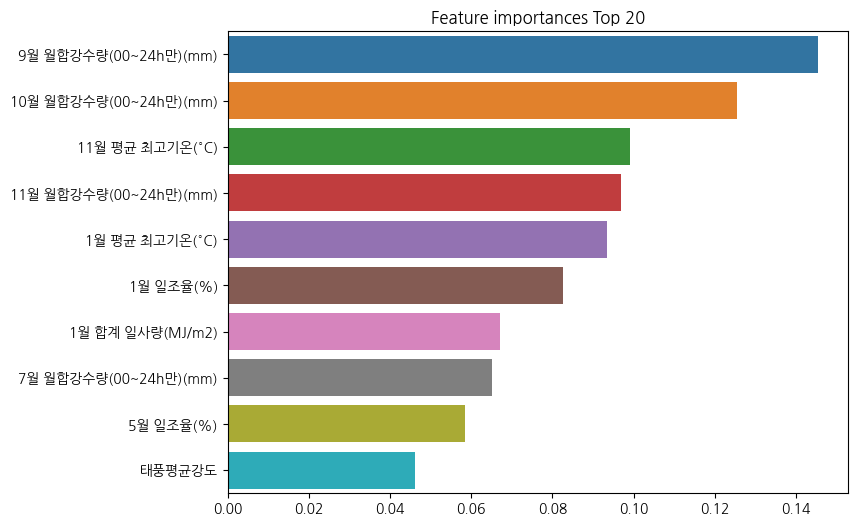

In [ ]:
ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
ftr_top20

9월 월합강수량(00~24h만)(mm)     0.145468
10월 월합강수량(00~24h만)(mm)    0.125537
11월 평균 최고기온(°C)           0.099041
11월 월합강수량(00~24h만)(mm)    0.096803
1월 평균 최고기온(°C)            0.093561
1월 일조율(%)                 0.082560
1월 합계 일사량(MJ/m2)          0.067072
7월 월합강수량(00~24h만)(mm)     0.065133
5월 일조율(%)                 0.058567
태풍평균강도                    0.046236
dtype: float64

## **3) SVM**

* grid search

In [ ]:
# SVM 모델을 생성합니다.
svm = SVC()

# 튜닝할 하이퍼파라미터 그리드를 정의합니다.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'decision_function_shape': ['ovr', 'ovo'],
}

# 그리드 서치
grid_search3 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search3.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 얻습니다.
best_params = grid_search3.best_params_
print('최적 하이퍼 파라미터:\n',grid_search3.best_params_)

최적 하이퍼 파라미터:
 {'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'poly'}


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_svm = grid_search3.best_estimator_

# 모델 학습
best_svm.fit(X_train, y_train)

# 검증 데이터 예측
y_pred3 = best_svm.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred3)

오차 행렬
[[12  4 11  0]
 [ 2 13 19  0]
 [ 6  3 97  2]
 [ 2  2 15 12]]
정확도: 0.6700, 정밀도: 0.6758, 재현율: 0.6700, F1:0.6468


## **4) gradientboosting**

* grid search

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
}

# GradientBoostingClassifier 모델 객체 생성
gb_model = GradientBoostingClassifier(random_state=42)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search4 = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search4.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search4.best_params_)
print("최고 정확도:", grid_search4.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
최고 정확도: 0.6755527638190953


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_gb = grid_search4.best_estimator_

# 모델 학습
best_gb.fit(X_train, y_train)

# 검증 데이터 예측
y_pred4 = best_gb.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred4)

오차 행렬
[[  7   1  19   0]
 [  1  13  20   0]
 [  0   1 105   2]
 [  0   1  18  12]]
정확도: 0.6850, 정밀도: 0.7391, 재현율: 0.6850, F1:0.6451


* feature importance

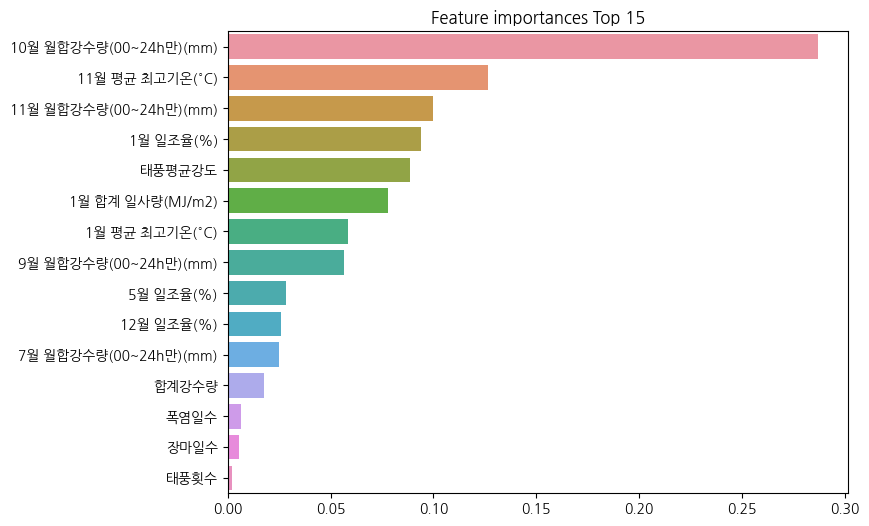

In [ ]:
ftr_importances_values = best_gb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

10월 월합강수량(00~24h만)(mm)    0.287036
11월 평균 최고기온(°C)           0.126764
11월 월합강수량(00~24h만)(mm)    0.099993
1월 일조율(%)                 0.094107
태풍평균강도                    0.088388
1월 합계 일사량(MJ/m2)          0.077783
1월 평균 최고기온(°C)            0.058699
9월 월합강수량(00~24h만)(mm)     0.056632
5월 일조율(%)                 0.028226
12월 일조율(%)                0.026060
dtype: float64

## **5) adaboost**

* grid search

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'base_estimator__max_depth': [1, 2, 3, 4]
}

# AdaBoostClassifier 모델 객체 생성
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search5 = GridSearchCV(estimator=ada_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search5.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search5.best_params_)
print("최고 정확도:", grid_search5.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarnin

최적의 하이퍼파라미터: {'base_estimator__max_depth': 4, 'learning_rate': 0.2, 'n_estimators': 100}
최고 정확도: 0.6671859296482411


* model fitting

In [ ]:
# 최적의 파라미터로 모델 생성
best_ada = grid_search5.best_estimator_

# 모델 학습
best_ada.fit(X_train, y_train)

# 검증 데이터 예측
y_pred5 = best_ada.predict(X_test)

* 모델 성능 평가

In [ ]:
get_clf_eval(y_test, y_pred5)

오차 행렬
[[  9   1  17   0]
 [  1  13  20   0]
 [  1   1 104   2]
 [  2   1  16  12]]
정확도: 0.6900, 정밀도: 0.7222, 재현율: 0.6900, F1:0.6557


* feature importance

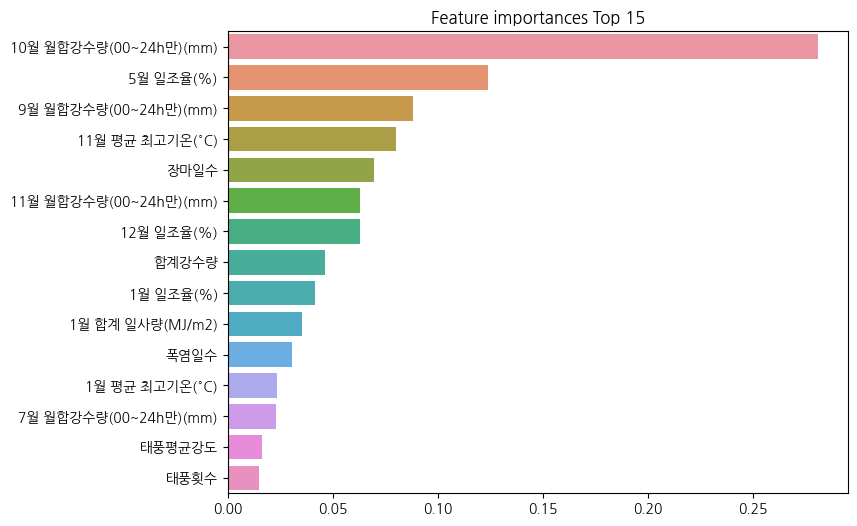

In [ ]:
ftr_importances_values = best_ada.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 15')
sns.barplot(x=ftr_top15, y=ftr_top15.index)
plt.show()

In [ ]:
ftr_importances.sort_values(ascending=False)[:10]

10월 월합강수량(00~24h만)(mm)    0.281082
5월 일조율(%)                 0.123857
9월 월합강수량(00~24h만)(mm)     0.088430
11월 평균 최고기온(°C)           0.079980
장마일수                      0.069474
11월 월합강수량(00~24h만)(mm)    0.063127
12월 일조율(%)                0.062784
합계강수량                     0.046228
1월 일조율(%)                 0.041475
1월 합계 일사량(MJ/m2)          0.035203
dtype: float64

## **6) 앙상블**

In [ ]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

# Voting Classifier를 사용하여 앙상블 생성
voting_classifier = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('ada', best_ada)],
    voting='hard'
    )

# Voting Classifier 학습
voting_classifier.fit(X_train, y_train)

# 각 모델의 예측을 얻을 수 있습니다.
xgb_predictions = best_xgb.predict(X_test)
rf_predictions = best_rf.predict(X_test)
ada_predictions = best_ada.predict(X_test)
voting_predictions = voting_classifier.predict(X_test)

# 성능 평가
get_clf_eval(y_test, voting_predictions)

오차 행렬
[[  9   1  17   0]
 [  1  13  20   0]
 [  1   1 104   2]
 [  2   1  16  12]]
정확도: 0.6900, 정밀도: 0.7222, 재현율: 0.6900, F1:0.6557


In [ ]:
# 스태킹 앙상블
from sklearn.ensemble import StackingClassifier

# 스태킹 앙상블 생성
stacking_models = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('ada', best_ada)
]

stacking_classifier = StackingClassifier(
    estimators=stacking_models
    )

# 스태킹 앙상블 모델 훈련
stacking_classifier.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
stacking_predictions = stacking_classifier.predict(X_test)

# 성능 평가
get_clf_eval(y_test, stacking_predictions)

오차 행렬
[[10  4 13  0]
 [ 2 13 19  0]
 [ 5  2 99  2]
 [ 0  1 18 12]]
정확도: 0.6700, 정밀도: 0.6816, 재현율: 0.6700, F1:0.6419


---

# **10. 상관분석에서 선택한 최종 모델**

- Voting Classifier

In [ ]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

# Voting Classifier를 사용하여 앙상블 생성
voting_classifier = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('ada', best_ada)],
    voting='hard'
    )

# Voting Classifier 학습
voting_classifier.fit(X_train, y_train)

# 각 모델의 예측을 얻을 수 있습니다.
xgb_predictions = best_xgb.predict(X_test)
rf_predictions = best_rf.predict(X_test)
ada_predictions = best_ada.predict(X_test)
voting_predictions = voting_classifier.predict(X_test)

# 성능 평가
get_clf_eval(y_test, voting_predictions)

오차 행렬
[[  9   1  17   0]
 [  1  13  20   0]
 [  1   1 104   2]
 [  2   1  16  12]]
정확도: 0.6900, 정밀도: 0.7222, 재현율: 0.6900, F1:0.6557
